Import Libraries

In [ ]:
import torch
import os
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)

device =  cuda


Load and Preprocess Test Set

In [ ]:
# Define dataset paths & transformations (use the same transformations as in the training script)
base_dir = '/content/drive/MyDrive/Colab Notebooks/COS30049_CTIP_Assignment/Species_Detection_Model/Resnet_Dataset/'
test_dir = os.path.join(base_dir, 'test')

image_size = 224
data_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the test dataset
test_dataset = ImageFolder(test_dir, data_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Load Trained Model

In [ ]:
# Load the saved model
model = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 64)  # Ensure this matches your model's output
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/COS30049_CTIP_Assignment/Species_Detection_Model/resnet50_model.pth'))
model.to(device)
model.eval()  # Set the model to evaluation mode

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 84.0MB/s]
<ipython-input-5-7541ea6ff7b3>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Model Evaluation

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                               precision    recall  f1-score   support

         asian black hornbill       1.00      1.00      1.00         3
                      babbler       1.00      1.00      1.00         2
                 banded civet       0.88      0.78      0.82         9
                banded langur       1.00      1.00      1.00         1
               banded linsang       0.33      0.67      0.44         3
                      bay cat       0.60      0.60      0.60         5
                     bear cat       0.80      0.80      0.80         5
                  bearded pig       0.73      0.80      0.76        10
                         bird       0.25      1.00      0.40         1
            blue banded pitta       1.00      1.00      1.00         2
     bornean crested fireback       1.00      1.00      1.00         2
        bornean ground cuckoo       1.00      1.00      1.00         7
            bornean porcupine       1.00      0.75      0.86         4
     

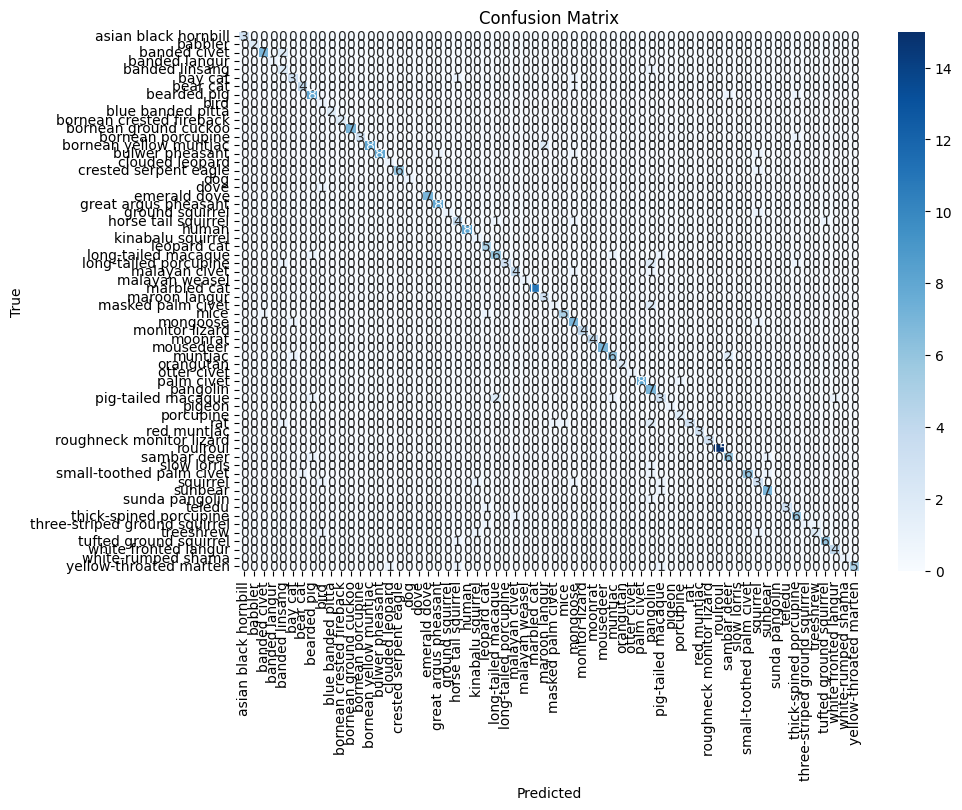

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define the evaluation function
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=dataloader.dataset.classes)
    print(report)

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataloader.dataset.classes, yticklabels=dataloader.dataset.classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Evaluate the model on the test set
evaluate_model(model, test_dataloader)